In [17]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from glob import glob
import torch
from sae_lens import SAE
from neuronpedia.np_sae_feature import SAEFeature
import configs
import json

In [18]:
def load_regression_weights(layer, use_sae, pickle_dir='pickles/regression_weights', brain_region='broca'):
    model_name = 'gemma2BSAE' if use_sae else 'gemma2B'
    filepath = os.path.join(pickle_dir, f'{brain_region}_{model_name}_L{layer}.pkl')
    with open(filepath, 'rb') as f:
        data = pickle.load(f)
    return data


In [19]:
model_layer = 12
use_sae = False

In [20]:
data = load_regression_weights(model_layer, use_sae)

In [21]:
W_llm_to_brain = data['best_estimator'].named_steps['ridge'].coef_


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
release = "gemma-scope-2b-pt-res-canonical"
sae_id = f"layer_{model_layer}/width_16k/canonical"
sae = SAE.from_pretrained(release, sae_id)[0].to(device)

In [23]:
W_llm_to_brain.shape

(193, 9216)

In [24]:
W_dec = sae.W_dec.detach().cpu().numpy()

In [25]:
W_features_to_llm = np.repeat(W_dec, 4, axis=1)
W_features_to_llm.shape

(16384, 9216)

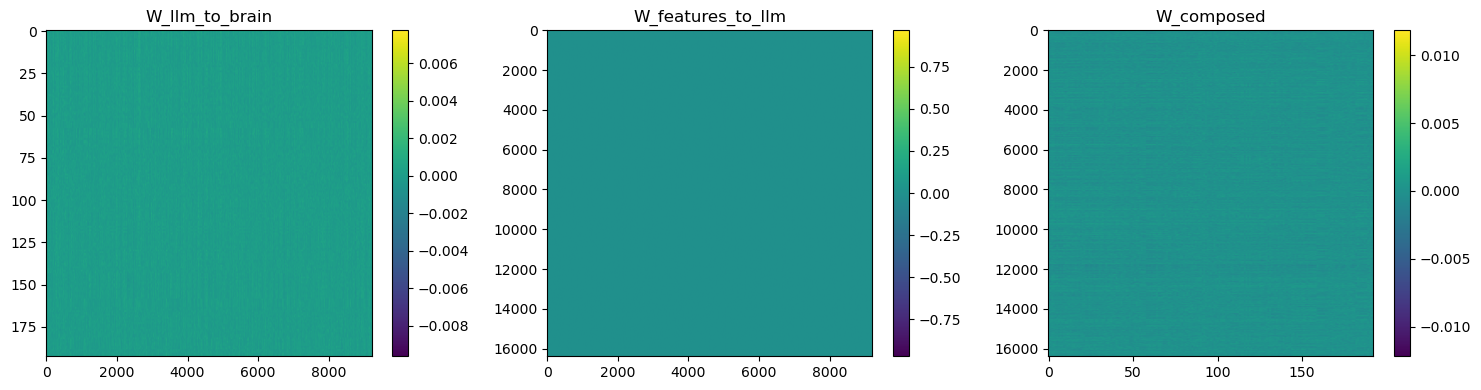

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Plot W_llm_to_brain
im1 = ax1.imshow(W_llm_to_brain, aspect='auto')
ax1.set_title('W_llm_to_brain')
plt.colorbar(im1, ax=ax1)

# Plot W_features_to_llm 
im2 = ax2.imshow(W_features_to_llm, aspect='auto')
ax2.set_title('W_features_to_llm')
plt.colorbar(im2, ax=ax2)

# Plot matrix multiplication
W_composed = W_features_to_llm @ W_llm_to_brain.T
im3 = ax3.imshow(W_composed, aspect='auto')
ax3.set_title('W_composed')
plt.colorbar(im3, ax=ax3)

plt.tight_layout()
plt.show()


In [27]:
W_composed.shape

(16384, 193)

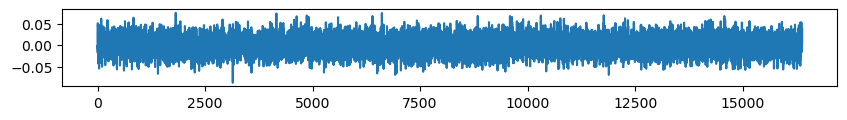

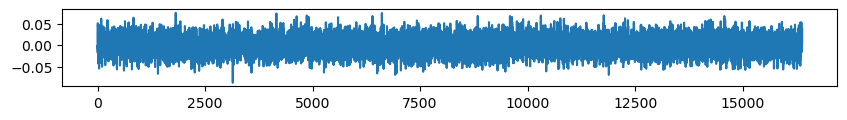

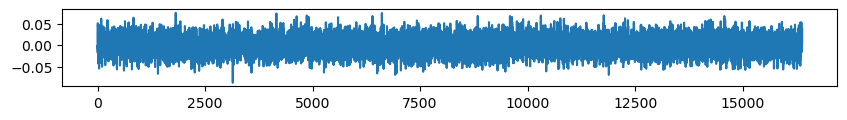

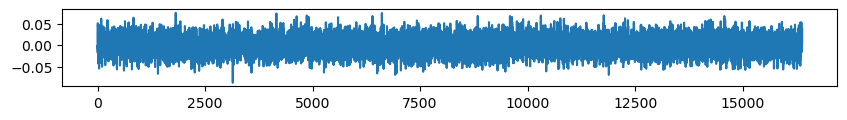

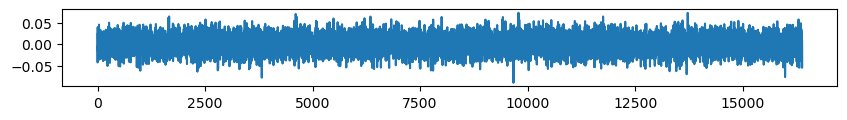

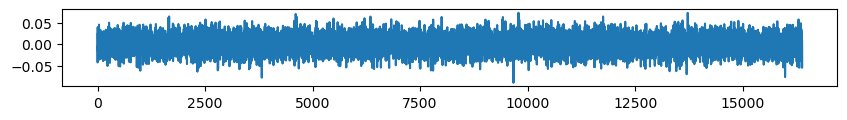

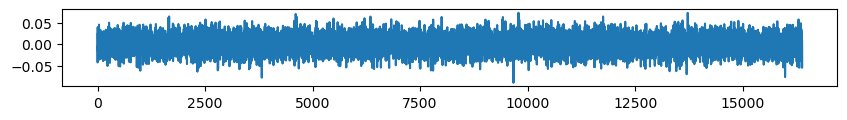

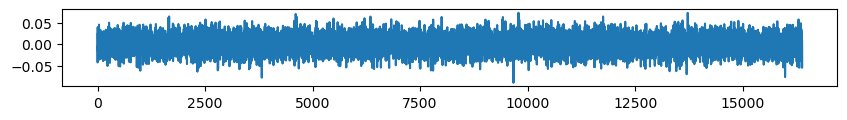

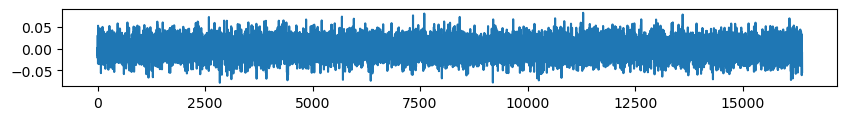

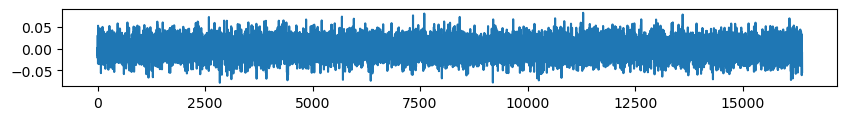

In [28]:
for unit in range(10):
    plt.figure(figsize=(10, 1))
    plt.plot(W_features_to_llm[:,unit])
    plt.show()


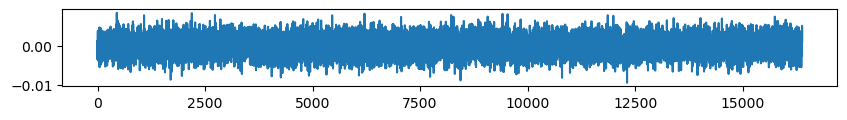

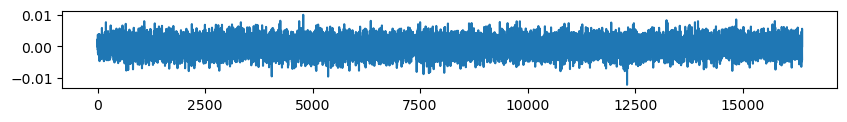

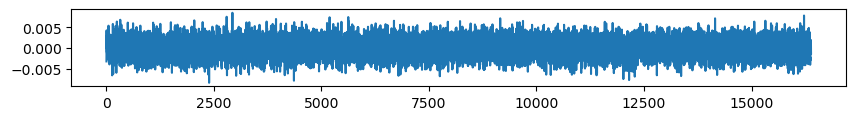

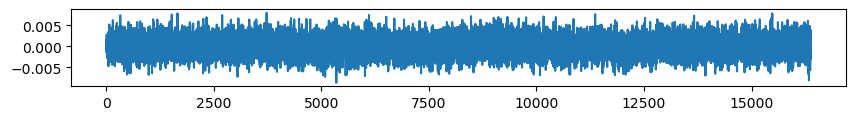

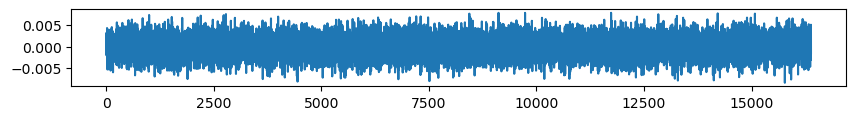

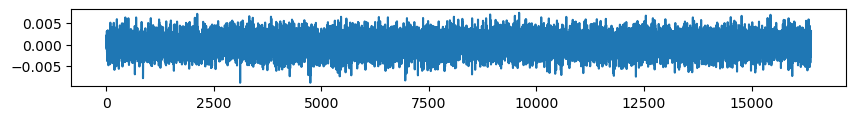

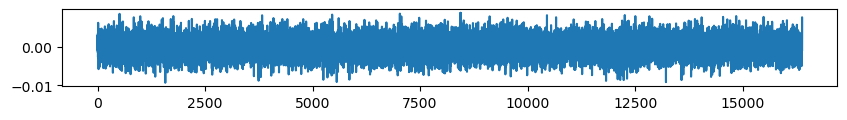

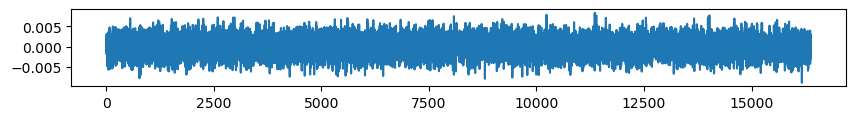

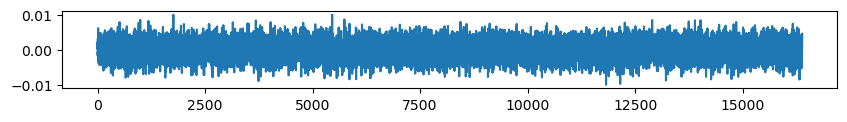

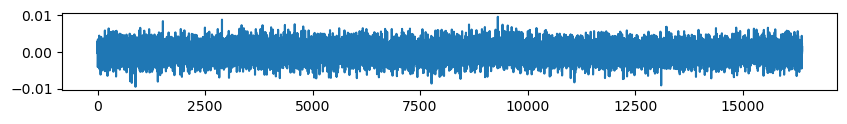

In [29]:
for voxel in range(10):
    plt.figure(figsize=(10, 1))
    plt.plot(W_composed[:,voxel])
    plt.show()

In [30]:
threshold = np.percentile(W_composed.flatten(), 99.9)
print(threshold)

0.006887886979030084


In [31]:
np.sum(W_composed[:,0] > threshold)

18

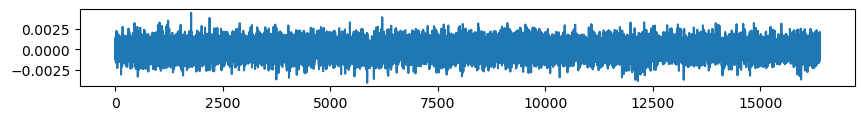

In [32]:
mean_loading = W_composed.mean(axis=1)
plt.figure(figsize=(10, 1))
plt.plot(mean_loading)
plt.show()


In [33]:
np.sum(mean_loading > 0.003)

23

In [43]:
descriptions = []
for feature_index in np.argwhere(mean_loading > 0.003):
    print(feature_index)
    sae_feature = SAEFeature.get("gemma-2-2b", "12-gemmascope-res-16k", f"{feature_index[0]}")
    feature_info = json.loads(sae_feature.jsonData)
    for i in feature_info['explanations']:
        descriptions.append(i['description'])


[447]
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/447
Got a successful response.
[1026]
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/1026
Got a successful response.
[1227]
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/1227
Got a successful response.
[1762]
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/1762
Got a successful response.
[2192]
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/2192
Got a successful response.
[2893]
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/2893
Got a successful response.
[3719]
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemmascope-res-16k/3719
Got a successful response.
[5455]
Sending GET request to https://neuronpedia.org/api/feature/gemma-2-2b/12-gemma

In [44]:
print(descriptions)

['expressions of personal emotions and concerns', 'instances of the word "respectively."', ' programming-related syntax and structures', ' coding language elements and structures', ' technical code syntax and structure', ' actions and experiences of individuals in distressing situations', 'terms related to the moon and lunar phenomena', ' mathematical symbols and variables used in formal expressions and equations', 'names and references related to authors and academic citations', 'references to ties and their related concepts or effects', 'terms related to extreme conditions or states', 'references to biblical or scriptural authority', 'keywords related to academic publishing and documentation', 'phrases that indicate requirements or conditions for options or settings', ' programming-related data structures, specifically lists and collections', 'instances of the word "Saturday" and references to time-related elements', 'references to campaigns and related metrics', 'information related